![image.png](https://i.imgur.com/a3uAqnb.png)

# Decision Trees and Ensemble Methods Lab
## Teen Phone Addiction Analysis

This comprehensive notebook demonstrates the power of **Decision Trees** and **Ensemble Methods** for both classification and regression tasks. We'll explore how these algorithms work, when to use them, and how ensemble methods can dramatically improve performance over single models.

### **📌 What We'll Cover:**

1. **Decision Trees**: Understanding how they make decisions through a series of if-else questions
2. **Ensemble Methods**: Combining multiple models for better predictions
   - **Random Forest**: Multiple trees with random feature selection
   - **AdaBoost**: Sequential learning from mistakes
   - **Gradient Boosting**: Iterative improvement of predictions
   - **XGBoost**: Optimized gradient boosting for production

### **🎯 Our Dataset: Teen Phone Addiction**
We'll use a dataset that examines factors contributing to phone addiction among teenagers. This is a relevant, real-world problem where we can predict addiction levels based on various behavioral and demographic features.

**Why This Dataset?**
- **Practical Relevance**: Understanding digital wellness is crucial in today's world
- **Mixed Data Types**: Contains both numerical and categorical features
- **Multiple Target Options**: We can approach this as both regression (predicting addiction score) and classification (categorizing addiction levels)

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Download and load the dataset
path = kagglehub.dataset_download("sumedh1507/teen-phone-addiction")
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset Shape: {df.shape}")
print(f"\n🔍 Column Information:")
print(f"{'Column Name':<25} {'Data Type':<12} {'Description'}")
print("-" * 60)

# Display basic information with descriptions
column_descriptions = {
    'ID': 'Unique identifier',
    'Name': 'Participant name', 
    'Age': 'Age in years',
    'Gender': 'Male/Female',
    'Phone_Usage_Hours': 'Daily phone usage',
    'School_Grade': 'Academic grade level',
    'Location': 'Geographic location',
    'Addiction_Level': 'Target variable (0-10 scale)'
}

for col, dtype in zip(df.columns, df.dtypes):
    desc = column_descriptions.get(col, 'Feature variable')
    print(f"{col:<25} {str(dtype):<12} {desc}")

✅ Dataset loaded successfully!
📊 Dataset Shape: (3000, 25)

🔍 Column Information:
Column Name               Data Type    Description
------------------------------------------------------------
ID                        int64        Unique identifier
Name                      object       Participant name
Age                       int64        Age in years
Gender                    object       Male/Female
Location                  object       Geographic location
School_Grade              object       Academic grade level
Daily_Usage_Hours         float64      Feature variable
Sleep_Hours               float64      Feature variable
Academic_Performance      int64        Feature variable
Social_Interactions       int64        Feature variable
Exercise_Hours            float64      Feature variable
Anxiety_Level             int64        Feature variable
Depression_Level          int64        Feature variable
Self_Esteem               int64        Feature variable
Parental_Control       

## 1️⃣ Exploratory Data Analysis & Feature Engineering

Before building our models, we need to understand our data deeply. This section will:

### **🔍 Key Analysis Steps:**
1. **Remove Non-Predictive Features**: Features like ID, Name, and Location don't help predict addiction
2. **Create Classification Target**: Convert continuous addiction scores to categories (Low, Medium, High, Severe)
3. **Feature Correlation Analysis**: Identify which features are most predictive
4. **Data Visualization**: Understand distributions and relationships

### **📊 Why Categorize Addiction Levels?**
While addiction level is naturally continuous (0-10 scale), creating categories allows us to:
- Compare classification vs regression approaches
- Make results more interpretable for practitioners
- Simulate real-world scenarios where we need discrete risk categories

### **🎨 Visualization Strategy:**
We'll create multiple visualizations to understand:
- Target variable distribution (both continuous and categorical)
- Feature correlations with addiction level
- Categorical feature relationships
- Overall feature correlation patterns

In [71]:
# Remove non-predictive features
features_to_drop = ['ID', 'Name', 'Location']
df_clean = df.drop(columns=features_to_drop)
print(f"✅ Dropped: {features_to_drop}")
print(f"📊 Remaining features: {df_clean.shape[1]} columns")

# Create categorical bins for classification
df_clean['Addiction_Category'] = pd.cut(df_clean['Addiction_Level'], 
                                       bins=[0, 3, 6, 8, 10], 
                                       labels=['Low', 'Medium', 'High', 'Severe'])

print(f"\n📊 Addiction Category Distribution:")
addiction_counts = df_clean['Addiction_Category'].value_counts().sort_index()
total_samples = len(df_clean)

for category, count in addiction_counts.items():
    percentage = (count / total_samples) * 100
    print(f"   {category:8s}: {count:4d} samples ({percentage:5.1f}%)")

✅ Dropped: ['ID', 'Name', 'Location']
📊 Remaining features: 22 columns

📊 Addiction Category Distribution:
   Low     :   14 samples (  0.5%)
   Medium  :  221 samples (  7.4%)
   High    :  517 samples ( 17.2%)
   Severe  : 2248 samples ( 74.9%)


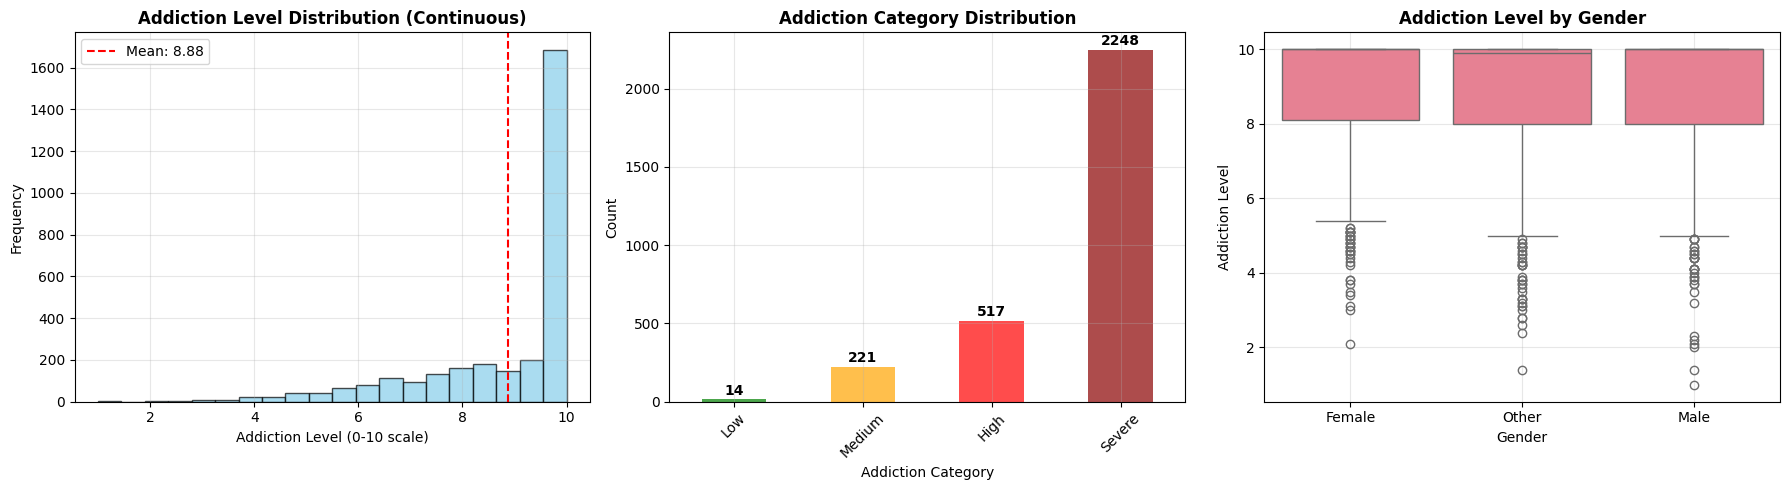

In [72]:
# Visualize target variable distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Continuous distribution
axes[0].hist(df_clean['Addiction_Level'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(df_clean['Addiction_Level'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_clean["Addiction_Level"].mean():.2f}')
axes[0].set_title('Addiction Level Distribution (Continuous)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Addiction Level (0-10 scale)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Categorical distribution
bars = addiction_counts.plot(kind='bar', ax=axes[1], color=['green', 'orange', 'red', 'darkred'], alpha=0.7)
axes[1].set_title('Addiction Category Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Addiction Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Add count labels on bars
for bar, count in zip(axes[1].patches, addiction_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                str(count), ha='center', va='bottom', fontweight='bold')

# Gender vs Addiction Level
sns.boxplot(data=df_clean, x='Gender', y='Addiction_Level', ax=axes[2])
axes[2].set_title('Addiction Level by Gender', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Gender')
axes[2].set_ylabel('Addiction Level')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🏆 Top Features Correlated with Addiction Level:
Rank Feature                   Correlation  Strength
------------------------------------------------------------
 1.  Daily_Usage_Hours            0.601     Strong
 2.  Apps_Used_Daily              0.319     Moderate
 3.  Time_on_Social_Media         0.307     Moderate
 4.  Time_on_Gaming               0.273     Weak
 5.  Phone_Checks_Per_Day         0.246     Weak
 6.  Sleep_Hours                  0.217     Weak
 7.  Age                          0.031     Weak
 8.  Self_Esteem                  0.022     Weak
 9.  Exercise_Hours               0.021     Weak
10.  Anxiety_Level                0.016     Weak


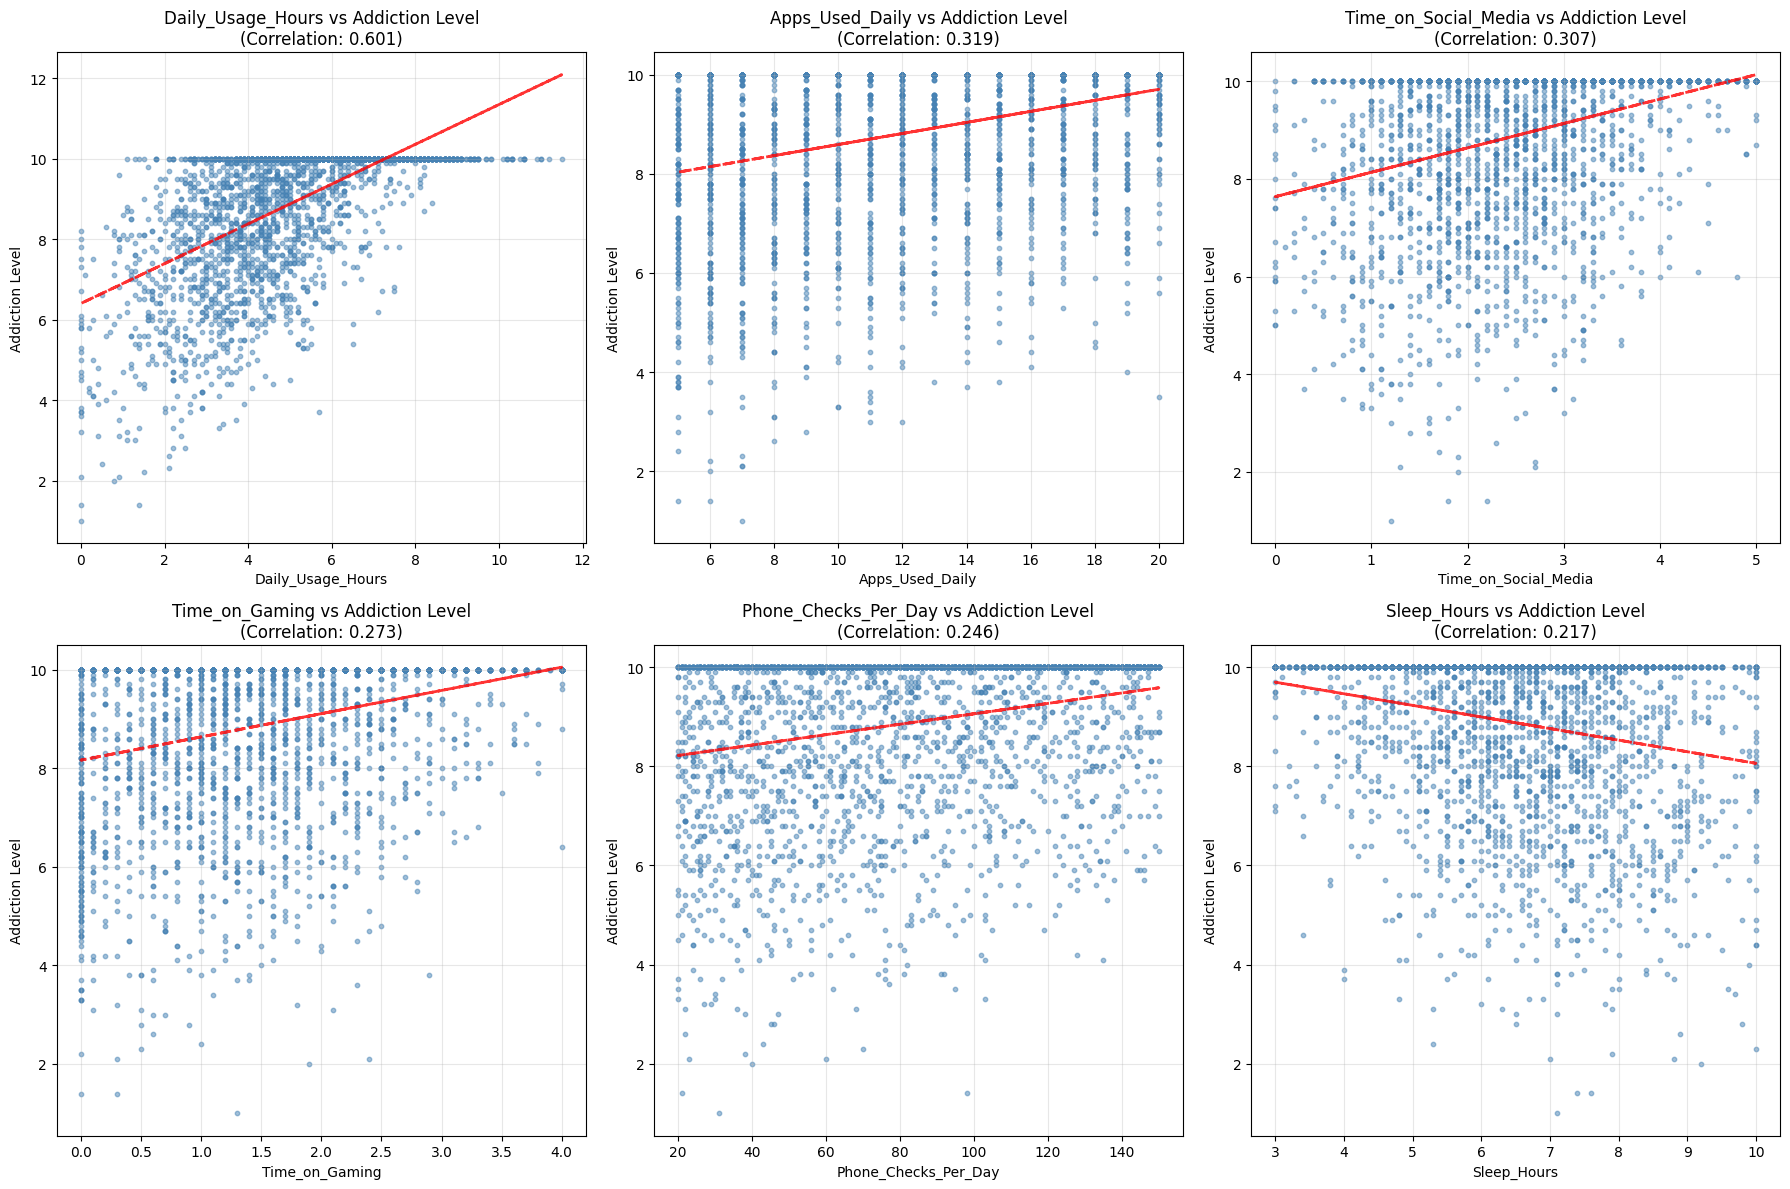

In [73]:
# Feature correlation analysis
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Addiction_Level')

# Calculate correlations with target variable
correlations = df_clean[numerical_features + ['Addiction_Level']].corr()['Addiction_Level'].abs().sort_values(ascending=False)

print(f"\n🏆 Top Features Correlated with Addiction Level:")
print(f"{'Rank':<4} {'Feature':<25} {'Correlation':<12} {'Strength'}")
print("-" * 60)

for i, (feature, corr) in enumerate(correlations[1:11].items(), 1):
    if corr >= 0.7:
        strength = "Very Strong"
    elif corr >= 0.5:
        strength = "Strong"
    elif corr >= 0.3:
        strength = "Moderate"
    else:
        strength = "Weak"
    
    print(f"{i:2d}.  {feature:<25} {corr:>8.3f}     {strength}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
top_features = correlations[1:7].index

for i, feature in enumerate(top_features):
    # Create scatter plot with trend line
    axes[i].scatter(df_clean[feature], df_clean['Addiction_Level'], alpha=0.5, s=10, color='steelblue')
    
    # Add trend line
    z = np.polyfit(df_clean[feature], df_clean['Addiction_Level'], 1)
    p = np.poly1d(z)
    axes[i].plot(df_clean[feature], p(df_clean[feature]), "r--", alpha=0.8, linewidth=2)
    
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Addiction Level')
    axes[i].set_title(f'{feature} vs Addiction Level\n(Correlation: {correlations[feature]:.3f})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [74]:
categorical_features = ['Gender', 'School_Grade', 'Phone_Usage_Purpose']

for feature in categorical_features:
    print(f"\n   📋 {feature} Analysis:")
    feature_stats = df_clean.groupby(feature)['Addiction_Level'].agg(['count', 'mean', 'std']).round(2)
    print(feature_stats)



   📋 Gender Analysis:
        count  mean   std
Gender                   
Female   1007  8.95  1.51
Male     1016  8.87  1.65
Other     977  8.83  1.67

   📋 School_Grade Analysis:
              count  mean   std
School_Grade                   
10th            487  8.84  1.64
11th            479  8.99  1.54
12th            529  8.83  1.68
7th             497  8.95  1.50
8th             482  8.82  1.69
9th             526  8.86  1.59

   📋 Phone_Usage_Purpose Analysis:
                     count  mean   std
Phone_Usage_Purpose                   
Browsing               627  8.90  1.56
Education              602  8.85  1.65
Gaming                 574  8.96  1.53
Other                  622  8.94  1.59
Social Media           575  8.75  1.72


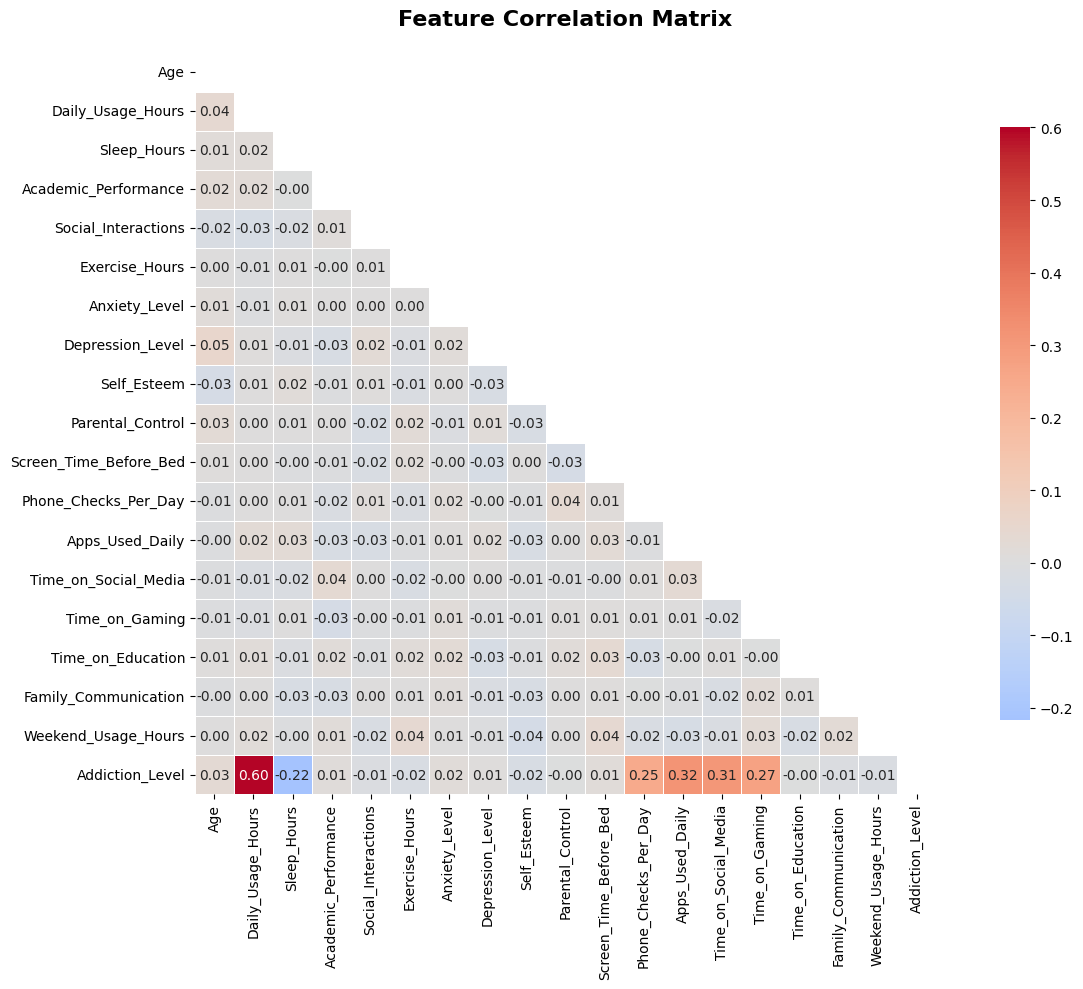

In [75]:
plt.figure(figsize=(14, 10))
correlation_matrix = df_clean[numerical_features + ['Addiction_Level']].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [76]:
# Prepare data for Decision Trees
from sklearn.preprocessing import LabelEncoder

df_encoded = df_clean.copy()
label_encoders = {}

# Encode categorical features
categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()
if 'Addiction_Category' in categorical_features:
    categorical_features.remove('Addiction_Category')

print(f"🏷️Encoding categorical features: {categorical_features}")

for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature] = le.fit_transform(df_encoded[feature])
    label_encoders[feature] = le
    print(f"   ✅ {feature}: {len(le.classes_)} unique values encoded")

# Create feature matrix and target vectors
X = df_encoded.drop(['Addiction_Level', 'Addiction_Category'], axis=1)
y_regression = df_encoded['Addiction_Level']
y_classification = df_encoded['Addiction_Category']

print(f"📊 Final Dataset Summary:")
print(f"   🎯 Features (X): {X.shape}")
print(f"   📈 Regression Target: {y_regression.shape}")
print(f"   🏷️  Classification Target: {y_classification.shape}")
print(f"   📋 Feature Names: {list(X.columns)}")

🏷️Encoding categorical features: ['Gender', 'School_Grade', 'Phone_Usage_Purpose']
   ✅ Gender: 3 unique values encoded
   ✅ School_Grade: 6 unique values encoded
   ✅ Phone_Usage_Purpose: 5 unique values encoded
📊 Final Dataset Summary:
   🎯 Features (X): (3000, 21)
   📈 Regression Target: (3000,)
   🏷️  Classification Target: (3000,)
   📋 Feature Names: ['Age', 'Gender', 'School_Grade', 'Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance', 'Social_Interactions', 'Exercise_Hours', 'Anxiety_Level', 'Depression_Level', 'Self_Esteem', 'Parental_Control', 'Screen_Time_Before_Bed', 'Phone_Checks_Per_Day', 'Apps_Used_Daily', 'Time_on_Social_Media', 'Time_on_Gaming', 'Time_on_Education', 'Phone_Usage_Purpose', 'Family_Communication', 'Weekend_Usage_Hours']


## 2️⃣ Building Our First Decision Tree

Decision trees are intuitive algorithms that make predictions by asking a series of yes/no questions. Think of it like a flowchart where each internal node represents a question about a feature, and each leaf represents a prediction.

### **🌳 How Decision Trees Work:**

1. **Root Node**: Starts with the entire dataset
2. **Splitting**: At each node, the algorithm chooses the best feature and threshold to split the data
3. **Criterion**: Uses metrics like **Gini impurity** (classification) or **MSE** (regression) to measure split quality
4. **Recursive Process**: Continues splitting until stopping criteria are met
5. **Leaf Nodes**: Final predictions are made at the leaves

### **⚖️ Regression vs Classification Trees:**

- **Regression Trees**: Predict continuous values (addiction score 0-10)
- **Classification Trees**: Predict categories (Low, Medium, High, Severe addiction)

### **🎛️ Key Hyperparameters:**

- **`max_depth`**: Maximum tree depth (prevents overfitting)
- **`min_samples_split`**: Minimum samples required to split a node
- **`min_samples_leaf`**: Minimum samples required in a leaf node
- **`criterion`**: Splitting criterion ('gini', 'entropy' for classification; 'mse' for regression)

### **🔍 What We'll Explore:**

1. **Overfitting Demonstration**: How tree depth affects performance
2. **Feature Importance**: Which features are most useful for predictions
3. **Tree Visualization**: See the actual decision-making process
4. **Model Interpretation**: Understand how predictions are made

In [77]:
# Stratified split for regression (using binned target)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42, stratify=pd.cut(y_regression, bins=5)
)

# Stratified split for classification
X_train_clf, X_test_clf, y_clf_train, y_clf_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"   ✅ Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   ✅ Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

   ✅ Training set: 2,400 samples (80.0%)
   ✅ Test set: 600 samples (20.0%)


In [78]:
# Create decision trees with different depths to show overfitting
depths = [3, 5, 10, None]
trees_reg = {}
mse_train = {}
mse_test = {}

print(f"\n📊 Training Trees with Different Depths...")
print(f"{'Depth':<12} {'Train MSE':<10} {'Test MSE':<10} {'Leaves':<8} {'Overfitting'}")
print("-" * 65)

for depth in depths:
    # Create and train decision tree
    tree = DecisionTreeRegressor(
        max_depth=depth,
        random_state=42,
        min_samples_split=20,  # Require at least 20 samples to split
        min_samples_leaf=10    # Require at least 10 samples in each leaf
    )
    
    tree.fit(X_train, y_reg_train)
    trees_reg[depth] = tree
    
    # Make predictions
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)
    
    # Calculate metrics
    mse_train[depth] = mean_squared_error(y_reg_train, train_pred)
    mse_test[depth] = mean_squared_error(y_reg_test, test_pred)
    overfitting = mse_test[depth] - mse_train[depth]
    
    depth_str = str(depth) if depth else 'Unlimited'
    print(f"{depth_str:<12} {mse_train[depth]:<10.3f} {mse_test[depth]:<10.3f} "
          f"{tree.get_n_leaves():<8} {overfitting:>+7.3f}")


📊 Training Trees with Different Depths...
Depth        Train MSE  Test MSE   Leaves   Overfitting
-----------------------------------------------------------------
3            1.297      1.401      8         +0.105
5            0.816      1.063      30        +0.247
10           0.385      0.765      136       +0.380
Unlimited    0.383      0.763      144       +0.380


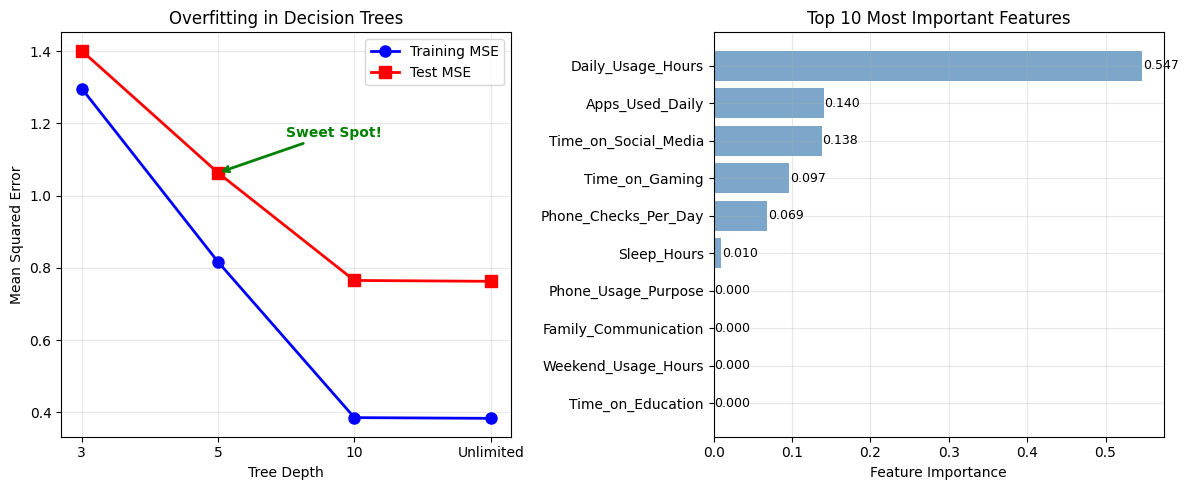

In [79]:
# Visualize overfitting and feature importance
plt.figure(figsize=(12, 5))

# Overfitting plot
plt.subplot(1, 2, 1)
depth_labels = [str(d) if d else 'Unlimited' for d in depths]
train_line = plt.plot(depth_labels, list(mse_train.values()), 'o-', 
                     label='Training MSE', linewidth=2, markersize=8, color='blue')
test_line = plt.plot(depth_labels, list(mse_test.values()), 's-', 
                    label='Test MSE', linewidth=2, markersize=8, color='red')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Overfitting in Decision Trees')
plt.legend()
plt.grid(True, alpha=0.3)

# Add annotations
for i, depth in enumerate(depth_labels):
    if i == 1:  # Highlight optimal depth
        plt.annotate('Sweet Spot!', xy=(i, list(mse_test.values())[i]), 
                    xytext=(i+0.5, list(mse_test.values())[i]+0.1),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2),
                    fontsize=10, fontweight='bold', color='green')

# Feature importance plot
plt.subplot(1, 2, 2)
best_tree = trees_reg[5]  # Use depth=5 as best performing
feature_importance = best_tree.feature_importances_

# Create importance dataframe and plot top 10
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True).tail(10)

bars = plt.barh(importance_df['Feature'], importance_df['Importance'], 
                color='steelblue', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, importance in zip(bars, importance_df['Importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [80]:
print(f"\n🏆 Top 5 Most Important Features (Regression Tree):")
feature_imp_sorted = sorted(zip(X.columns, feature_importance), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(feature_imp_sorted[:5], 1):
    print(f"   {i}. {feature:<20}: {importance:.3f}")


🏆 Top 5 Most Important Features (Regression Tree):
   1. Daily_Usage_Hours   : 0.547
   2. Apps_Used_Daily     : 0.140
   3. Time_on_Social_Media: 0.138
   4. Time_on_Gaming      : 0.097
   5. Phone_Checks_Per_Day: 0.069


In [81]:
# Build classification tree
tree_clf = DecisionTreeClassifier(
    max_depth=5,
    random_state=42,
    min_samples_split=20,
    min_samples_leaf=10,
    criterion='entropy'  # Using information gain (entropy) for splitting
)

tree_clf.fit(X_train_clf, y_clf_train)

# Make predictions
y_pred_train = tree_clf.predict(X_train_clf)
y_pred_test = tree_clf.predict(X_test_clf)

# Calculate accuracies
train_accuracy = accuracy_score(y_clf_train, y_pred_train)
test_accuracy = accuracy_score(y_clf_test, y_pred_test)

print(f"\n📊 Classification Results:")
print(f"   🎯 Training Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"   🎯 Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"   🌳 Tree Depth: {tree_clf.get_depth()}")
print(f"   🍃 Number of Leaves: {tree_clf.get_n_leaves()}")
print(f"   📈 Overfitting: {(train_accuracy - test_accuracy):+.3f}")

print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_clf_test, y_pred_test))


📊 Classification Results:
   🎯 Training Accuracy: 0.814 (81.4%)
   🎯 Test Accuracy: 0.768 (76.8%)
   🌳 Tree Depth: 5
   🍃 Number of Leaves: 31
   📈 Overfitting: +0.046

📋 Detailed Classification Report:
              precision    recall  f1-score   support

        High       0.41      0.52      0.46       103
         Low       0.00      0.00      0.00         3
      Medium       0.39      0.30      0.34        44
      Severe       0.91      0.88      0.89       450

    accuracy                           0.77       600
   macro avg       0.43      0.42      0.42       600
weighted avg       0.78      0.77      0.77       600



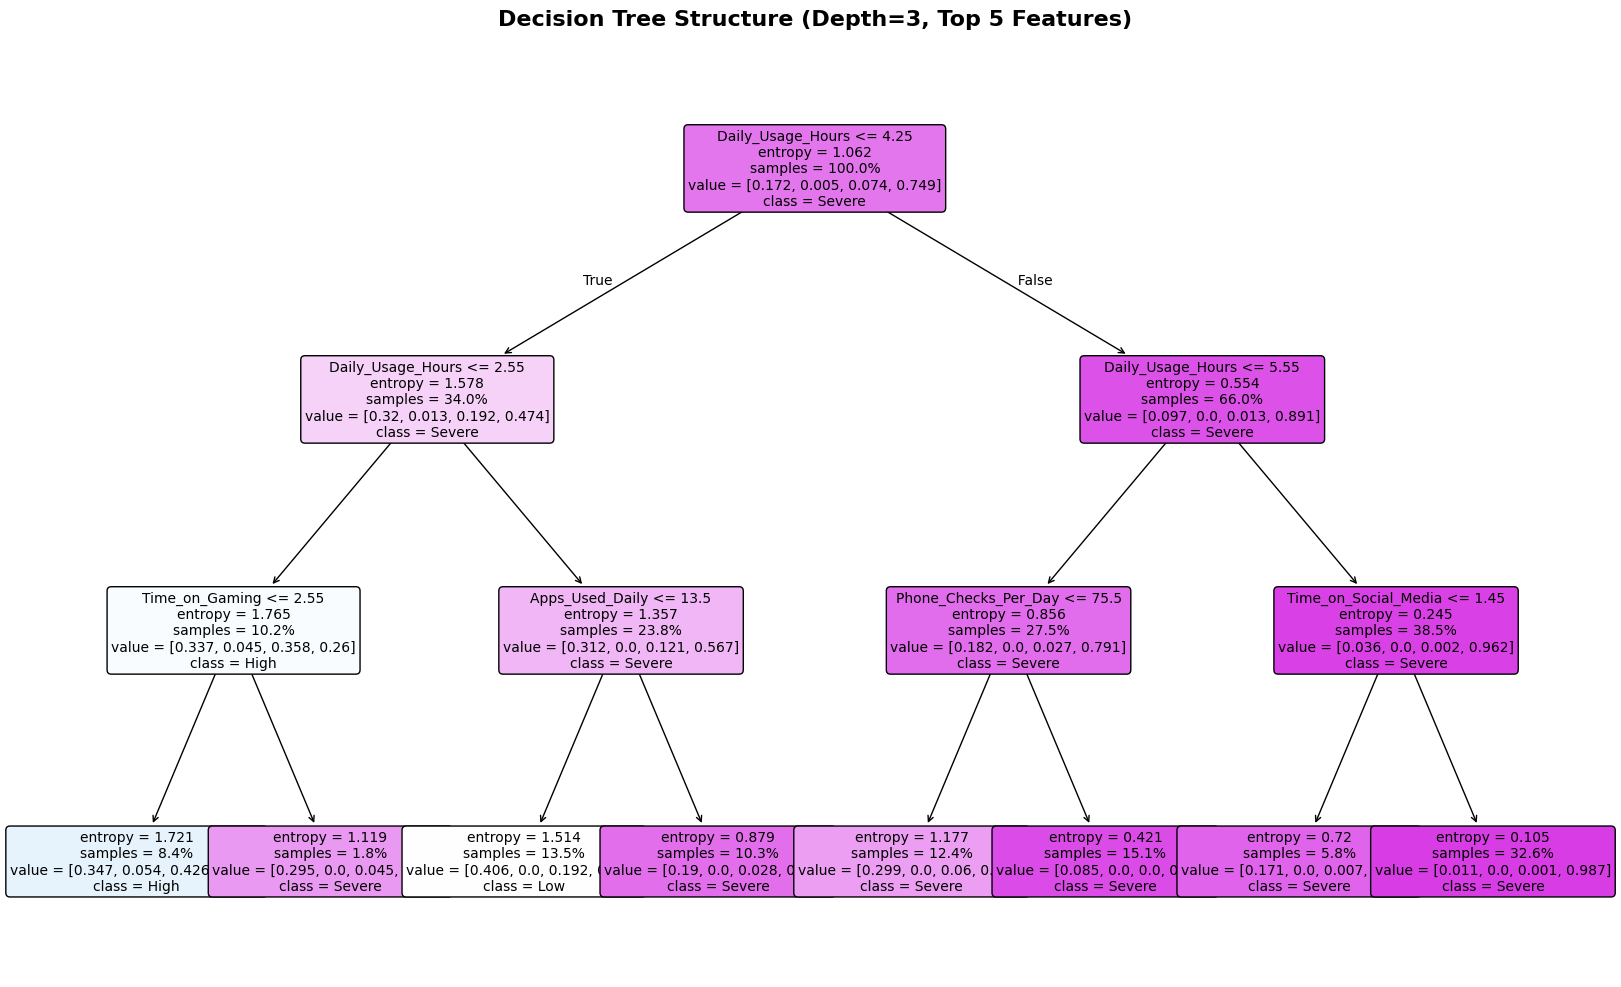

In [82]:
# Create a smaller tree for visualization
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42, 
                                   min_samples_split=50, criterion='entropy')
top_features = [feat for feat, _ in feature_imp_sorted[:5]]
X_small = X_train_clf[top_features]
small_tree.fit(X_small, y_clf_train)

plt.figure(figsize=(20, 12))
plot_tree(small_tree, 
          feature_names=top_features,
          class_names=['Low', 'Medium', 'High', 'Severe'],
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True,  # Show proportions instead of raw counts
          impurity=True)    # Show impurity values
plt.title('Decision Tree Structure (Depth=3, Top 5 Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

In [83]:
# Sample prediction walkthrough
sample_idx = 42
sample = X_test_clf.iloc[sample_idx]
true_label = y_clf_test.iloc[sample_idx]
predicted_label = tree_clf.predict([sample])[0]
prediction_proba = tree_clf.predict_proba([sample])[0]

print(f"📋 Sample #{sample_idx + 1} Details:")
print(f"   🎯 True Label: {true_label}")
print(f"   🤖 Predicted Label: {predicted_label}")
print(f"   ✅ Correct: {'Yes' if true_label == predicted_label else 'No'}")

print(f"\n📊 Prediction Probabilities:")
class_names = ['Low', 'Medium', 'High', 'Severe']
for class_name, prob in zip(class_names, prediction_proba):
    confidence_bar = '█' * int(prob * 20)  # Visual probability bar
    print(f"   {class_name:8s}: {prob:.3f} {confidence_bar}")

print(f"\n🎯 Highest Confidence: {prediction_proba.max():.3f}")


📋 Sample #43 Details:
   🎯 True Label: Severe
   🤖 Predicted Label: Severe
   ✅ Correct: Yes

📊 Prediction Probabilities:
   Low     : 0.043 
   Medium  : 0.000 
   High    : 0.014 
   Severe  : 0.943 ██████████████████

🎯 Highest Confidence: 0.943


In [84]:
# Show feature values for this sample
print(f"\n📋 Sample Feature Values:")
for feature, value in sample.items():
    print(f"   {feature:<20}: {value}")

# Decision path
leaf_id = tree_clf.apply([sample])
print(f"\n🌳 Tree Navigation: Sample reached leaf node #{leaf_id[0]}")


📋 Sample Feature Values:
   Age                 : 19.0
   Gender              : 1.0
   School_Grade        : 0.0
   Daily_Usage_Hours   : 4.2
   Sleep_Hours         : 8.3
   Academic_Performance: 81.0
   Social_Interactions : 7.0
   Exercise_Hours      : 1.6
   Anxiety_Level       : 9.0
   Depression_Level    : 10.0
   Self_Esteem         : 8.0
   Parental_Control    : 1.0
   Screen_Time_Before_Bed: 0.4
   Phone_Checks_Per_Day: 96.0
   Apps_Used_Daily     : 20.0
   Time_on_Social_Media: 1.9
   Time_on_Gaming      : 3.8
   Time_on_Education   : 0.3
   Phone_Usage_Purpose : 1.0
   Family_Communication: 10.0
   Weekend_Usage_Hours : 5.3

🌳 Tree Navigation: Sample reached leaf node #29


## 3️⃣ Ensemble Methods: The Power of Many Trees

Single decision trees, while interpretable, often suffer from **high variance** - small changes in data can lead to very different trees. **Ensemble methods** solve this by combining multiple models to create more robust and accurate predictions.

### **🌲 Why Ensemble Methods Work:**

1. **Bias-Variance Tradeoff**: Ensembles reduce variance while maintaining low bias
2. **Wisdom of Crowds**: Multiple "opinions" are often better than one
3. **Error Reduction**: Individual model errors can cancel out
4. **Robustness**: Less sensitive to outliers and noise

### **🎯 Ensemble Methods We'll Explore:**

#### **1. Random Forest (Bagging)**
- **Concept**: Train many trees on different subsets of data and features
- **Key Idea**: Reduce variance through averaging
- **Strengths**: Robust, handles missing values, provides feature importance
- **Best For**: General-purpose tasks, feature selection

#### **2. AdaBoost (Adaptive Boosting)**
- **Concept**: Sequential learning where each tree focuses on previous mistakes
- **Key Idea**: Convert weak learners into strong learners
- **Strengths**: Good for binary classification, simple to understand
- **Best For**: Binary classification, when you have weak learners

#### **3. Gradient Boosting**
- **Concept**: Sequentially add models that correct residual errors
- **Key Idea**: Optimize loss function directly
- **Strengths**: High accuracy, handles different loss functions
- **Best For**: When accuracy is paramount, structured data

#### **4. XGBoost (Extreme Gradient Boosting)**
- **Concept**: Optimized gradient boosting with regularization
- **Key Idea**: Speed and performance optimization
- **Strengths**: Production-ready, excellent performance, built-in regularization
- **Best For**: Competitions, production systems, large datasets

### **⚡ Performance Comparison:**
We'll compare all methods on:
- **Accuracy**: How often they make correct predictions
- **Overfitting**: Training vs test performance gap
- **Training Time**: Computational efficiency
- **Feature Importance**: Which features matter most

In [85]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import time

n_estimators_list = [1, 10, 50, 100, 200]
rf_results = {}

print(f"\n📊 Training Random Forests with Different Tree Counts...")
print(f"{'Trees':<8} {'Train Acc':<10} {'Test Acc':<10} {'Improvement':<12} {'Time (s)'}")
print("-" * 60)

baseline_accuracy = test_accuracy  # From single decision tree

for n_trees in n_estimators_list:
    start_time = time.time()
    
    rf_clf = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=5,
        random_state=42,
        max_features='sqrt',    # √(number of features) for each tree
        min_samples_split=20,
        min_samples_leaf=10,
        n_jobs=-1              # Use all CPU cores
    )
    
    rf_clf.fit(X_train_clf, y_clf_train)
    
    train_acc = rf_clf.score(X_train_clf, y_clf_train)
    test_acc = rf_clf.score(X_test_clf, y_clf_test)
    training_time = time.time() - start_time
    improvement = ((test_acc - baseline_accuracy) / baseline_accuracy * 100)
    
    rf_results[n_trees] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'time': training_time
    }
    
    print(f"{n_trees:<8} {train_acc:<10.3f} {test_acc:<10.3f} {improvement:>+8.1f}%    {training_time:>7.2f}")

# Train best Random Forest
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    max_features='sqrt',
    min_samples_split=20,
    min_samples_leaf=10
)
best_rf.fit(X_train_clf, y_clf_train)

print(f"\n🏆 Random Forest vs Single Decision Tree:")
print(f"   🌳 Single Tree Test Accuracy: {test_accuracy:.3f}")
print(f"   🌲 Random Forest Test Accuracy: {rf_results[100]['test_acc']:.3f}")
print(f"   📈 Improvement: {((rf_results[100]['test_acc'] - test_accuracy) / test_accuracy * 100):+.1f}%")
print(f"   🎯 Overfitting Reduction: {(train_accuracy - test_accuracy) - (rf_results[100]['train_acc'] - rf_results[100]['test_acc']):+.3f}")


📊 Training Random Forests with Different Tree Counts...
Trees    Train Acc  Test Acc   Improvement  Time (s)
------------------------------------------------------------
1        0.778      0.757          -1.5%       0.02
10       0.771      0.755          -1.7%       0.06
50       0.755      0.752          -2.2%       0.11
100      0.754      0.752          -2.2%       0.18
200      0.755      0.752          -2.2%       0.36

🏆 Random Forest vs Single Decision Tree:
   🌳 Single Tree Test Accuracy: 0.768
   🌲 Random Forest Test Accuracy: 0.752
   📈 Improvement: -2.2%
   🎯 Overfitting Reduction: +0.044


In [86]:
ada_clf = AdaBoostClassifier(
   n_estimators=100,
   learning_rate=1.0,
   random_state=42
)

print(f"\n🔧 Training AdaBoost Classifier...")
start_time = time.time()
ada_clf.fit(X_train_clf, y_clf_train)
ada_time = time.time() - start_time

ada_train_acc = ada_clf.score(X_train_clf, y_clf_train)
ada_test_acc = ada_clf.score(X_test_clf, y_clf_test)

print(f"   ✅ Training completed in {ada_time:.2f} seconds")
print(f"   🎯 AdaBoost Train Accuracy: {ada_train_acc:.3f}")
print(f"   🎯 AdaBoost Test Accuracy: {ada_test_acc:.3f}")
print(f"   📊 Overfitting: {ada_train_acc - ada_test_acc:+.3f}")


🔧 Training AdaBoost Classifier...
   ✅ Training completed in 0.24 seconds
   🎯 AdaBoost Train Accuracy: 0.843
   🎯 AdaBoost Test Accuracy: 0.830
   📊 Overfitting: +0.013


In [87]:
gb_clf = GradientBoostingClassifier(
   n_estimators=100,
   learning_rate=0.1,
   max_depth=3,
   random_state=42
)

print(f"\n🔧 Training Gradient Boosting Classifier...")
start_time = time.time()
gb_clf.fit(X_train_clf, y_clf_train)
gb_time = time.time() - start_time

gb_train_acc = gb_clf.score(X_train_clf, y_clf_train)
gb_test_acc = gb_clf.score(X_test_clf, y_clf_test)

print(f"   ✅ Training completed in {gb_time:.2f} seconds")
print(f"   🎯 Gradient Boosting Train Accuracy: {gb_train_acc:.3f}")
print(f"   🎯 Gradient Boosting Test Accuracy: {gb_test_acc:.3f}")
print(f"   📊 Overfitting: {gb_train_acc - gb_test_acc:+.3f}")


🔧 Training Gradient Boosting Classifier...
   ✅ Training completed in 1.35 seconds
   🎯 Gradient Boosting Train Accuracy: 0.991
   🎯 Gradient Boosting Test Accuracy: 0.897
   📊 Overfitting: +0.095


In [88]:
methods = ['Single Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
test_accuracies = [test_accuracy, rf_results[100]['test_acc'], ada_test_acc, gb_test_acc]
train_accuracies = [train_accuracy, rf_results[100]['train_acc'], ada_train_acc, gb_train_acc]
training_times = [0.1, rf_results[100]['time'], ada_time, gb_time]  # Approximate for single tree

print(f"{'Method':<18} {'Train Acc':<10} {'Test Acc':<10} {'Overfitting':<12} {'Time (s)'}")
print("-" * 70)

for method, train_acc, test_acc, time_taken in zip(methods, train_accuracies, test_accuracies, training_times):
   overfitting = train_acc - test_acc
   print(f"{method:<18} {train_acc:>8.3f}  {test_acc:>8.3f}  {overfitting:>+9.3f}    {time_taken:>7.2f}")

Method             Train Acc  Test Acc   Overfitting  Time (s)
----------------------------------------------------------------------
Single Tree           0.814     0.768     +0.046       0.10
Random Forest         0.754     0.752     +0.002       0.18
AdaBoost              0.843     0.830     +0.013       0.24
Gradient Boosting     0.991     0.897     +0.095       1.35


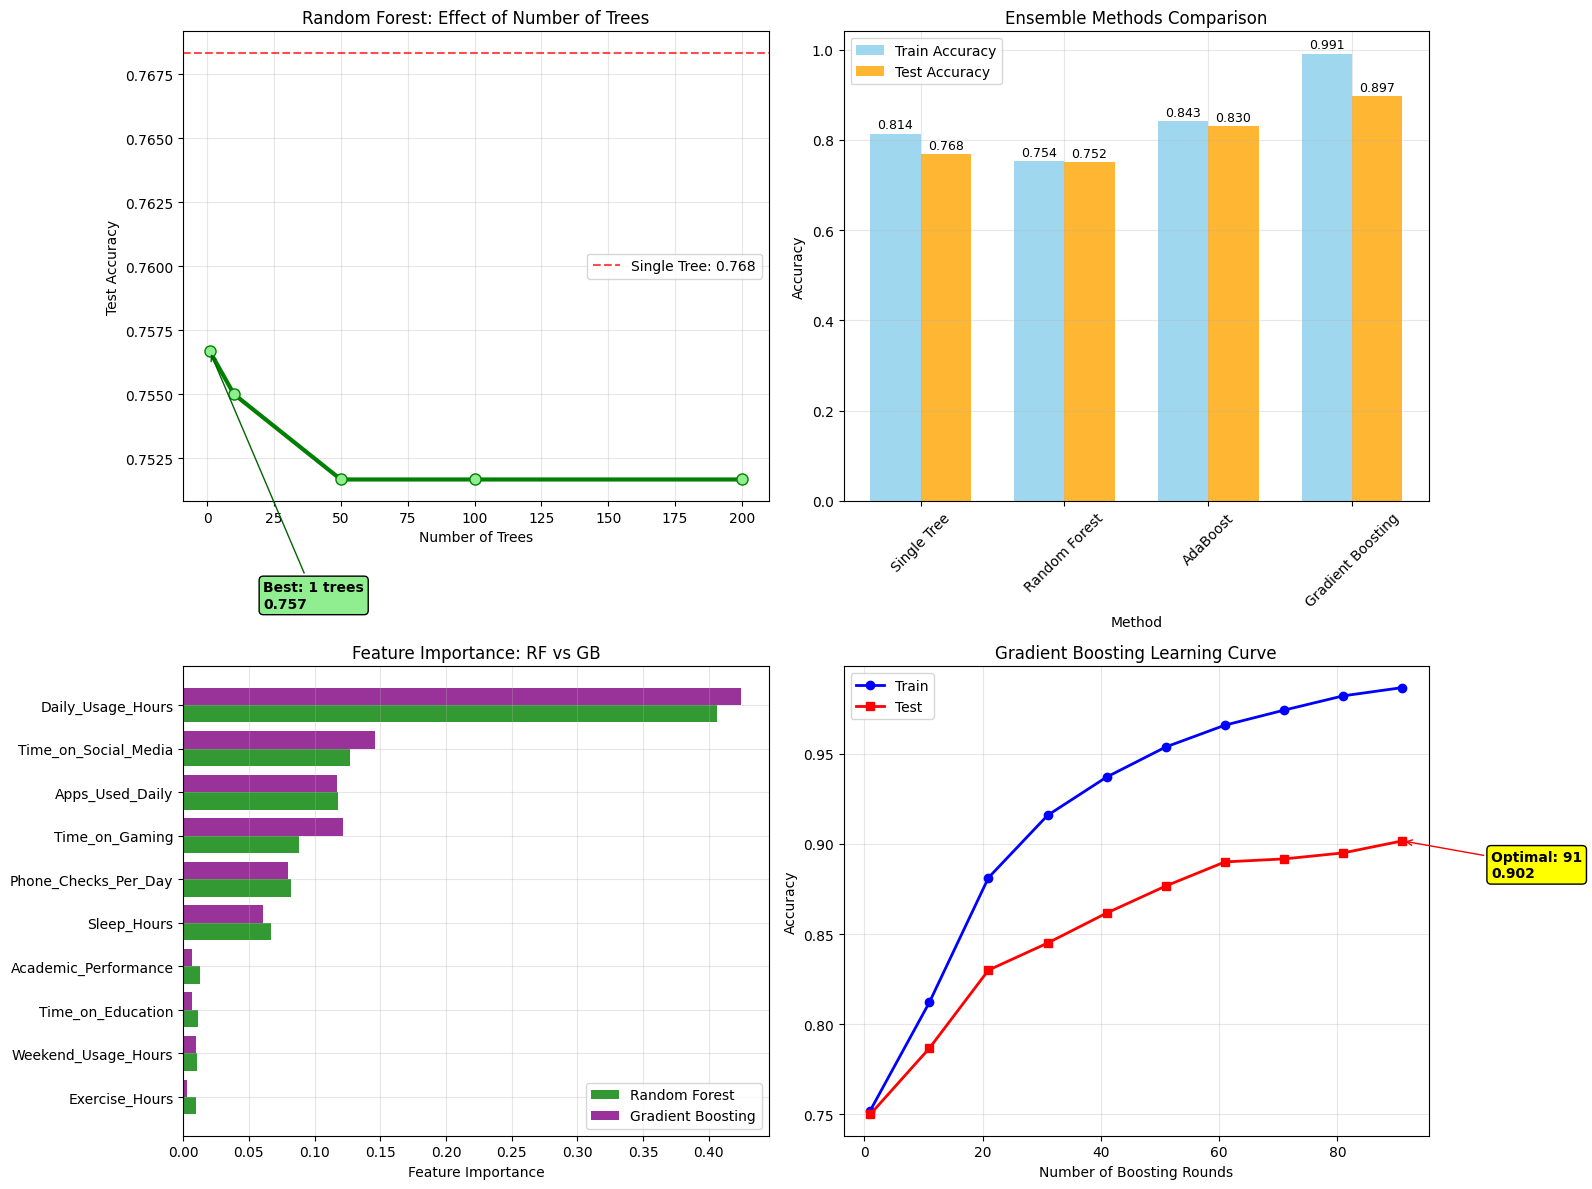

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Random Forest: Number of trees effect
axes[0, 0].plot(list(rf_results.keys()), [rf_results[k]['test_acc'] for k in rf_results.keys()], 
               'o-', linewidth=3, markersize=8, color='green', markerfacecolor='lightgreen')
axes[0, 0].axhline(y=test_accuracy, color='red', linestyle='--', alpha=0.7, 
                  label=f'Single Tree: {test_accuracy:.3f}')
axes[0, 0].set_xlabel('Number of Trees')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Random Forest: Effect of Number of Trees')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add annotations for key points
max_acc_idx = list(rf_results.values()).index(max(rf_results.values(), key=lambda x: x['test_acc']))
max_trees = list(rf_results.keys())[max_acc_idx]
max_acc = rf_results[max_trees]['test_acc']
axes[0, 0].annotate(f'Best: {max_trees} trees\n{max_acc:.3f}', 
                   xy=(max_trees, max_acc), xytext=(max_trees+20, max_acc-0.01),
                   arrowprops=dict(arrowstyle='->', color='darkgreen'),
                   fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

# 2. Methods comparison
x_pos = np.arange(len(methods))
width = 0.35

bars1 = axes[0, 1].bar(x_pos - width/2, train_accuracies, width, 
                      label='Train Accuracy', alpha=0.8, color='skyblue')
bars2 = axes[0, 1].bar(x_pos + width/2, test_accuracies, width, 
                      label='Test Accuracy', alpha=0.8, color='orange')

axes[0, 1].set_xlabel('Method')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Ensemble Methods Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(methods, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
   for bar in bars:
       height = bar.get_height()
       axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Feature importance comparison
rf_importance = best_rf.feature_importances_
gb_importance = gb_clf.feature_importances_

top_features_idx = np.argsort(rf_importance)[-10:]
y_pos = np.arange(len(top_features_idx))

axes[1, 0].barh(y_pos - 0.2, rf_importance[top_features_idx], 0.4, 
               alpha=0.8, label='Random Forest', color='green')
axes[1, 0].barh(y_pos + 0.2, gb_importance[top_features_idx], 0.4, 
               alpha=0.8, label='Gradient Boosting', color='purple')

axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels([X.columns[i] for i in top_features_idx])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Feature Importance: RF vs GB')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Learning curves for Gradient Boosting
gb_train_scores = []
gb_test_scores = []

for i in range(1, 101, 10):
   gb_temp = GradientBoostingClassifier(n_estimators=i, learning_rate=0.1, 
                                       max_depth=3, random_state=42)
   gb_temp.fit(X_train_clf, y_clf_train)
   gb_train_scores.append(gb_temp.score(X_train_clf, y_clf_train))
   gb_test_scores.append(gb_temp.score(X_test_clf, y_clf_test))

estimator_range = range(1, 101, 10)
axes[1, 1].plot(estimator_range, gb_train_scores, 'o-', label='Train', 
               linewidth=2, markersize=6, color='blue')
axes[1, 1].plot(estimator_range, gb_test_scores, 's-', label='Test', 
               linewidth=2, markersize=6, color='red')

axes[1, 1].set_xlabel('Number of Boosting Rounds')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Gradient Boosting Learning Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add optimal point annotation
optimal_idx = np.argmax(gb_test_scores)
optimal_estimators = list(estimator_range)[optimal_idx]
optimal_score = gb_test_scores[optimal_idx]
axes[1, 1].annotate(f'Optimal: {optimal_estimators}\n{optimal_score:.3f}', 
                   xy=(optimal_estimators, optimal_score), 
                   xytext=(optimal_estimators+15, optimal_score-0.02),
                   arrowprops=dict(arrowstyle='->', color='red'),
                   fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))

plt.tight_layout()
plt.show()

In [90]:
# Best performing method
best_idx = np.argmax(test_accuracies)
best_method = methods[best_idx]
best_score = test_accuracies[best_idx]

print(f"🏆 Best Performing Method: {best_method}")
print(f"   🎯 Test Accuracy: {best_score:.3f} ({best_score*100:.1f}%)")
print(f"   📈 Improvement over Single Tree: {((best_score - test_accuracy) / test_accuracy * 100):+.1f}%")

# Overfitting analysis
overfitting_scores = [train_acc - test_acc for train_acc, test_acc in zip(train_accuracies, test_accuracies)]
least_overfitting_idx = np.argmin(overfitting_scores)
least_overfitting_method = methods[least_overfitting_idx]

print(f"\n🛡️  Best Generalization: {least_overfitting_method}")
print(f"   📊 Overfitting Score: {overfitting_scores[least_overfitting_idx]:+.3f}")

# Speed analysis
fastest_idx = np.argmin(training_times)
fastest_method = methods[fastest_idx]

print(f"\n⚡ Fastest Training: {fastest_method}")
print(f"   ⏱️  Training Time: {training_times[fastest_idx]:.2f} seconds")

print(f"\n📊 Method Recommendations:")
print(f"   🏆 Highest Accuracy: {best_method}")
print(f"   🛡️  Best Generalization: {least_overfitting_method}")  
print(f"   ⚡ Fastest Training: {fastest_method}")
print(f"   🎯 Most Interpretable: Single Tree")

print(f"\n✅ Ensemble Methods Analysis Complete!")

🏆 Best Performing Method: Gradient Boosting
   🎯 Test Accuracy: 0.897 (89.7%)
   📈 Improvement over Single Tree: +16.7%

🛡️  Best Generalization: Random Forest
   📊 Overfitting Score: +0.002

⚡ Fastest Training: Single Tree
   ⏱️  Training Time: 0.10 seconds

📊 Method Recommendations:
   🏆 Highest Accuracy: Gradient Boosting
   🛡️  Best Generalization: Random Forest
   ⚡ Fastest Training: Single Tree
   🎯 Most Interpretable: Single Tree

✅ Ensemble Methods Analysis Complete!


## 4️⃣ Advanced Topics: XGBoost and Model Interpretability

In this final section, we'll explore **XGBoost** (Extreme Gradient Boosting), the algorithm that has dominated machine learning competitions and real-world applications for years. We'll also dive deep into **model interpretability** to understand not just *what* our models predict, but *why* they make those predictions.

### **🚀 XGBoost: The Competition Winner**

XGBoost is an optimized distributed gradient boosting library designed to be highly **efficient**, **flexible**, and **portable**. It's the algorithm behind many winning solutions in machine learning competitions.

#### **Key Advantages of XGBoost:**
1. **Speed**: Highly optimized C++ implementation
2. **Performance**: Often achieves state-of-the-art results
3. **Regularization**: Built-in L1 and L2 regularization
4. **Missing Values**: Handles missing data automatically
5. **Feature Importance**: Multiple ways to measure feature importance
6. **Cross-validation**: Built-in cross-validation capabilities

### **🔍 Model Interpretability: Understanding the Black Box**

While ensemble methods often achieve high accuracy, they can be harder to interpret than single decision trees. We'll explore several approaches to understand our models:

#### **Feature Importance Analysis:**
1. **Gain-based Importance**: How much each feature contributes to decreasing impurity
2. **Split-based Importance**: How often each feature is used for splitting
3. **Permutation Importance**: How much performance drops when a feature is shuffled

#### **Consistency Analysis:**
- **Cross-Model Comparison**: Which features are consistently important across different algorithms?
- **Stability Metrics**: How stable are our feature importance rankings?

### **🎯 What We'll Accomplish:**
1. **Train XGBoost**: Compare against our previous ensemble methods
2. **Feature Importance Deep Dive**: Multiple perspectives on what matters
3. **Model Stability Analysis**: How consistent are our findings?
4. **Practical Recommendations**: Which method to choose for different scenarios
5. **Interpretability Tools**: Techniques for explaining model decisions

In [91]:
import xgboost as xgb
from sklearn.inspection import permutation_importance

# Convert string labels to numeric for XGBoost
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_clf_train_numeric = le_target.fit_transform(y_clf_train)
y_clf_test_numeric = le_target.transform(y_clf_test)

print(f"   🔧 Label encoding: {dict(enumerate(le_target.classes_))}")

# XGBoost with carefully tuned hyperparameters
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,          # Use 80% of samples for each tree
    colsample_bytree=0.8,   # Use 80% of features for each tree
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob'  # Multi-class classification
)

print(f"\n🔧 Training XGBoost Classifier...")
start_time = time.time()
xgb_clf.fit(X_train_clf, y_clf_train_numeric, 
           eval_set=[(X_test_clf, y_clf_test_numeric)], 
           verbose=False)
xgb_time = time.time() - start_time

xgb_train_acc = xgb_clf.score(X_train_clf, y_clf_train_numeric)
xgb_test_acc = xgb_clf.score(X_test_clf, y_clf_test_numeric)

print(f"   ✅ Training completed in {xgb_time:.2f} seconds")
print(f"   🎯 XGBoost Train Accuracy: {xgb_train_acc:.3f}")
print(f"   🎯 XGBoost Test Accuracy: {xgb_test_acc:.3f}")
print(f"   📊 Overfitting: {xgb_train_acc - xgb_test_acc:+.3f}")

   🔧 Label encoding: {0: 'High', 1: 'Low', 2: 'Medium', 3: 'Severe'}

🔧 Training XGBoost Classifier...
   ✅ Training completed in 0.18 seconds
   🎯 XGBoost Train Accuracy: 0.972
   🎯 XGBoost Test Accuracy: 0.885
   📊 Overfitting: +0.087


In [92]:
# Update our methods and results
all_methods = ['Single Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost']
all_test_accuracies = [test_accuracy, rf_results[100]['test_acc'], ada_test_acc, gb_test_acc, xgb_test_acc]
all_train_accuracies = [train_accuracy, rf_results[100]['train_acc'], ada_train_acc, gb_train_acc, xgb_train_acc]
all_training_times = [0.1, rf_results[100]['time'], ada_time, gb_time, xgb_time]

# Detailed comparison table
print(f"{'Method':<18} {'Train':<8} {'Test':<8} {'Gap':<8} {'Time':<8} {'Rank'}")
print("-" * 65)

# Calculate rankings
test_ranks = [sorted(all_test_accuracies, reverse=True).index(acc) + 1 for acc in all_test_accuracies]

for i, (method, train_acc, test_acc, time_taken, rank) in enumerate(
    zip(all_methods, all_train_accuracies, all_test_accuracies, all_training_times, test_ranks)):
    
    gap = train_acc - test_acc
    
    # Add emoji indicators
    rank_emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "📊"
    
    print(f"{method:<18} {train_acc:.3f}  {test_acc:.3f}  {gap:+.3f}  {time_taken:6.2f}s  {rank_emoji} #{rank}")


Method             Train    Test     Gap      Time     Rank
-----------------------------------------------------------------
Single Tree        0.814  0.768  +0.046    0.10s  📊 #4
Random Forest      0.754  0.752  +0.002    0.18s  📊 #5
AdaBoost           0.843  0.830  +0.013    0.24s  🥉 #3
Gradient Boosting  0.991  0.897  +0.095    1.35s  🥇 #1
XGBoost            0.972  0.885  +0.087    0.18s  🥈 #2



🏆 TOP 10 MOST IMPORTANT FEATURES
Rank Feature              Avg Imp  Std      Consistency
------------------------------------------------------------
 1.  Daily_Usage_Hours    0.360  0.122  🟡 Medium
 2.  Time_on_Social_Media 0.125  0.021  🟢 High
 3.  Apps_Used_Daily      0.116  0.013  🟢 High
 4.  Time_on_Gaming       0.102  0.014  🟢 High
 5.  Phone_Checks_Per_Day 0.093  0.020  🟢 High
 6.  Sleep_Hours          0.056  0.017  🟢 High
 7.  Academic_Performance 0.016  0.017  🔴 Low
 8.  Social_Interactions  0.015  0.018  🔴 Low
 9.  Exercise_Hours       0.012  0.015  🔴 Low
10.  Time_on_Education    0.012  0.012  🔴 Low


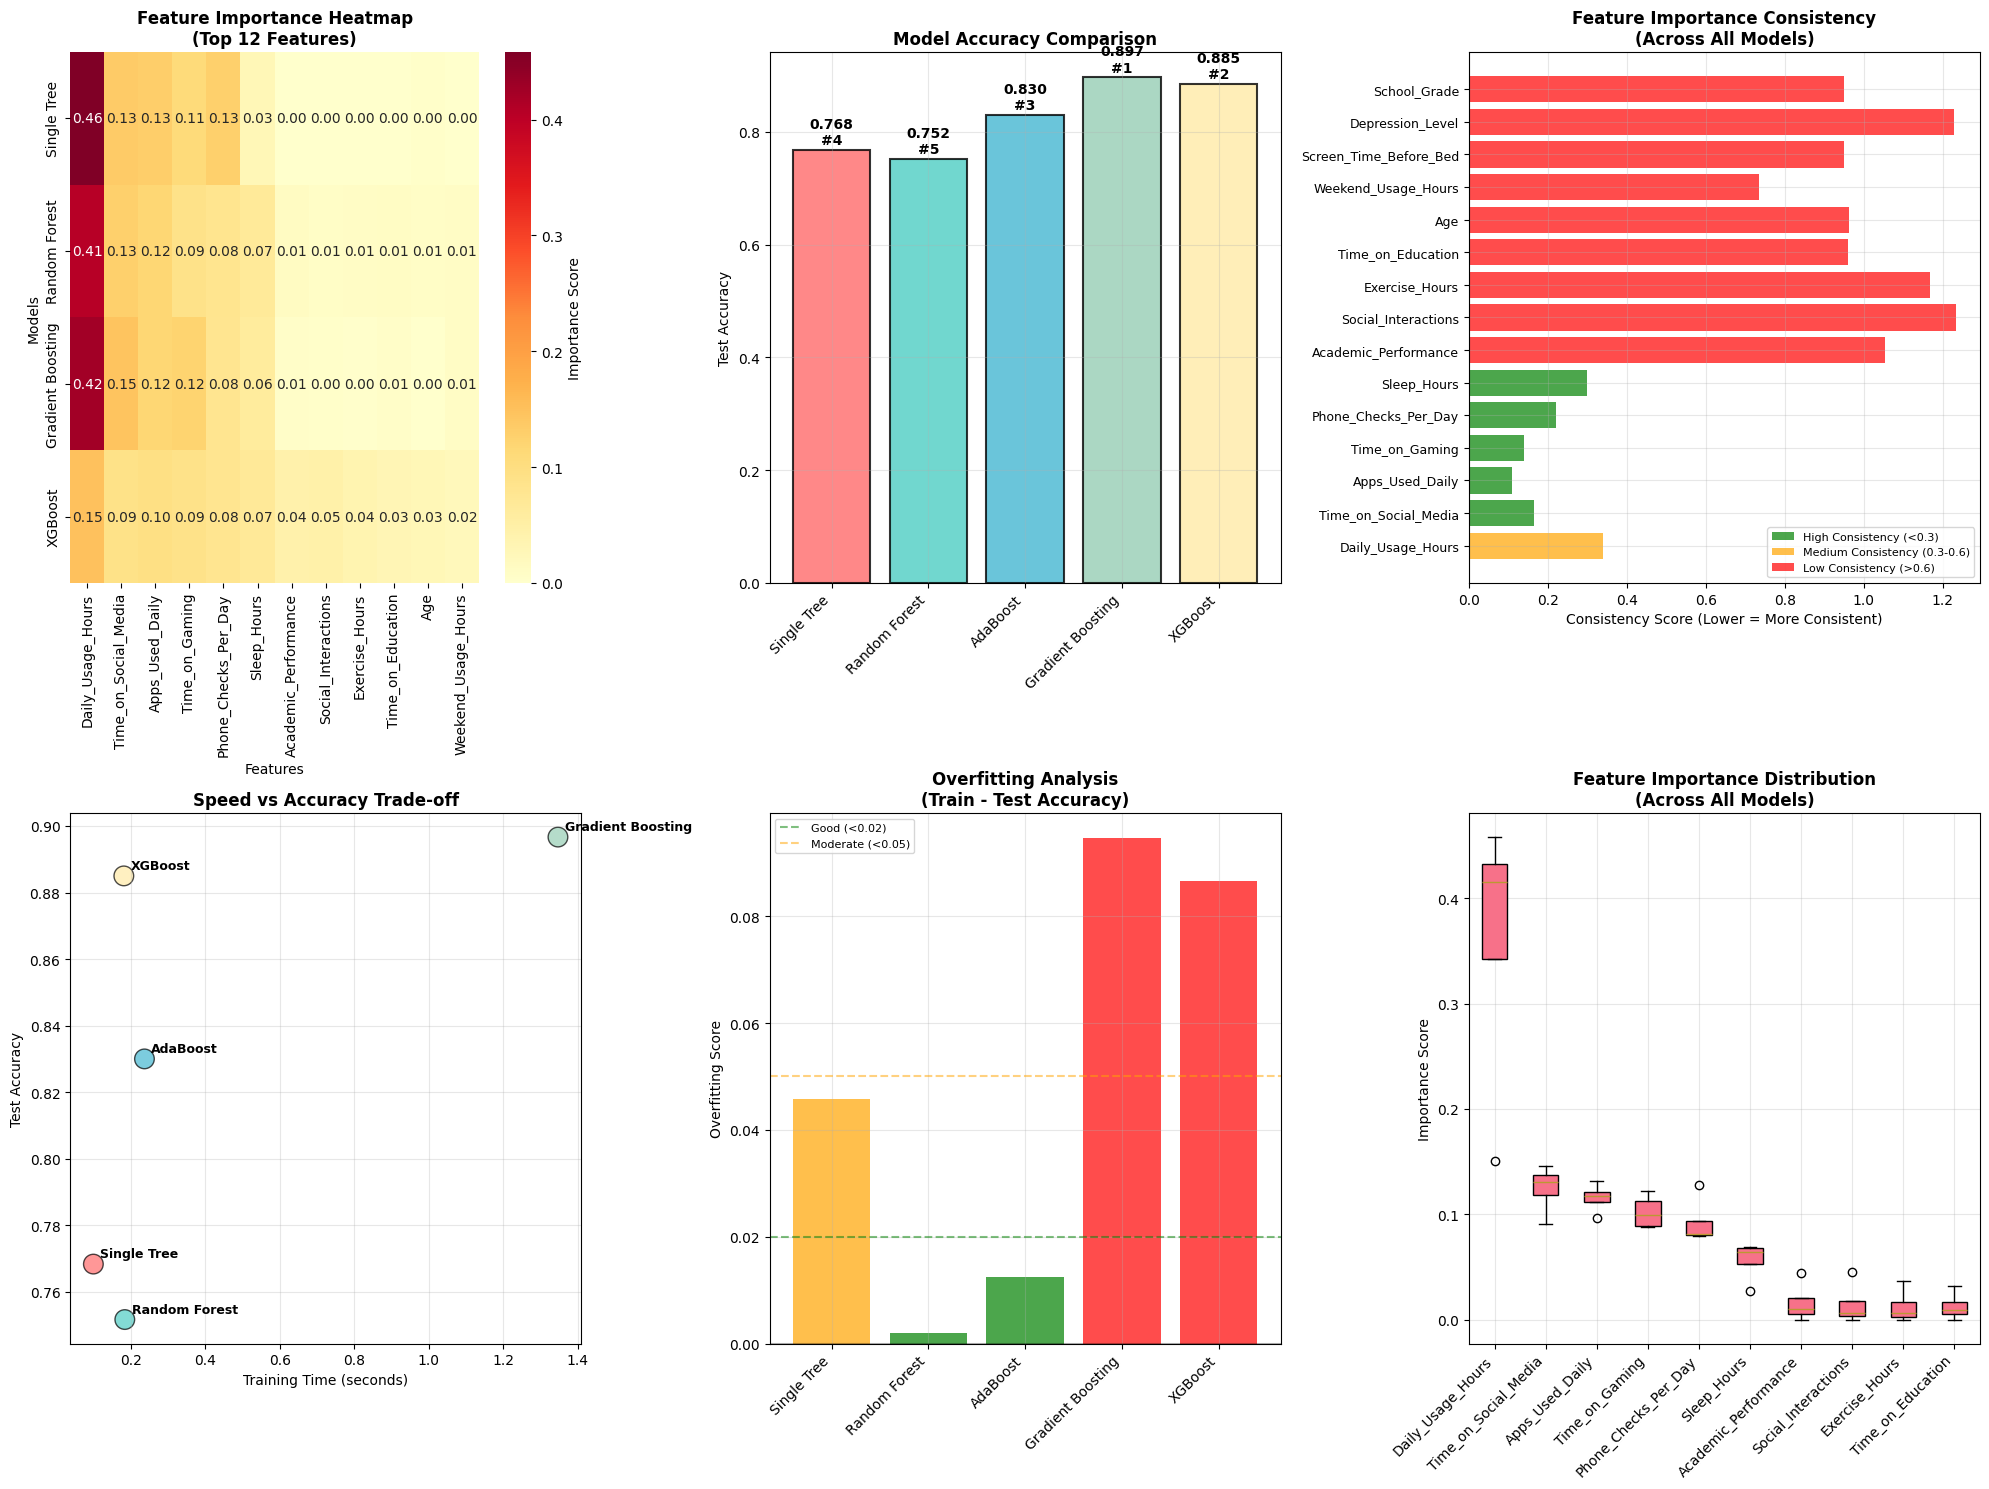

In [93]:
# Collect feature importance from all tree-based models
models_importance = {
    'Single Tree': tree_clf.feature_importances_,
    'Random Forest': best_rf.feature_importances_,
    'Gradient Boosting': gb_clf.feature_importances_,
    'XGBoost': xgb_clf.feature_importances_
}

# Create comprehensive importance comparison
importance_df = pd.DataFrame(models_importance, index=X.columns)
importance_df['Average'] = importance_df.mean(axis=1)
importance_df['Std'] = importance_df.std(axis=1)
importance_df['Consistency'] = importance_df['Std'] / importance_df['Average']  # Coefficient of variation
importance_df = importance_df.sort_values('Average', ascending=False)

print(f"\n🏆 TOP 10 MOST IMPORTANT FEATURES")
print(f"{'Rank':<4} {'Feature':<20} {'Avg Imp':<8} {'Std':<8} {'Consistency'}")
print("-" * 60)

for i, (feature, row) in enumerate(importance_df.head(10).iterrows(), 1):
    avg_importance = row['Average']
    std_importance = row['Std']
    consistency = row['Consistency']
    
    # Consistency rating
    if consistency < 0.3:
        consistency_rating = "🟢 High"
    elif consistency < 0.6:
        consistency_rating = "🟡 Medium"
    else:
        consistency_rating = "🔴 Low"
    
    print(f"{i:2d}.  {feature:<20} {avg_importance:.3f}  {std_importance:.3f}  {consistency_rating}")


plt.figure(figsize=(20, 15))

# 1. Feature importance heatmap (top 12 features)
plt.subplot(2, 3, 1)
top_12_features = importance_df.head(12).index
heatmap_data = importance_df.loc[top_12_features, list(models_importance.keys())].T

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', 
           cbar_kws={'label': 'Importance Score'})
plt.title('Feature Importance Heatmap\n(Top 12 Features)', fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Models')

# 2. Model accuracy comparison with error bars
plt.subplot(2, 3, 2)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = plt.bar(range(len(all_methods)), all_test_accuracies, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

plt.title('Model Accuracy Comparison', fontweight='bold')
plt.ylabel('Test Accuracy')
plt.xticks(range(len(all_methods)), all_methods, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels and rankings
for i, (bar, acc, rank) in enumerate(zip(bars, all_test_accuracies, test_ranks)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}\n#{rank}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

# 3. Feature importance consistency analysis
plt.subplot(2, 3, 3)
consistency_scores = importance_df.head(15)['Consistency']
colors_consistency = ['green' if x < 0.3 else 'orange' if x < 0.6 else 'red' for x in consistency_scores]

bars = plt.barh(range(len(consistency_scores)), consistency_scores, color=colors_consistency, alpha=0.7)
plt.yticks(range(len(consistency_scores)), consistency_scores.index, fontsize=9)
plt.xlabel('Consistency Score (Lower = More Consistent)')
plt.title('Feature Importance Consistency\n(Across All Models)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='High Consistency (<0.3)'),
                  Patch(facecolor='orange', alpha=0.7, label='Medium Consistency (0.3-0.6)'),
                  Patch(facecolor='red', alpha=0.7, label='Low Consistency (>0.6)')]
plt.legend(handles=legend_elements, loc='lower right', fontsize=8)

# 4. Training time vs accuracy scatter plot
plt.subplot(2, 3, 4)
plt.scatter(all_training_times, all_test_accuracies, s=200, c=colors, alpha=0.7, edgecolors='black')

for i, method in enumerate(all_methods):
    plt.annotate(method, (all_training_times[i], all_test_accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy')
plt.title('Speed vs Accuracy Trade-off', fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Overfitting analysis
plt.subplot(2, 3, 5)
overfitting_scores = [train - test for train, test in zip(all_train_accuracies, all_test_accuracies)]
colors_overfitting = ['green' if x < 0.02 else 'orange' if x < 0.05 else 'red' for x in overfitting_scores]

bars = plt.bar(range(len(all_methods)), overfitting_scores, color=colors_overfitting, alpha=0.7)
plt.title('Overfitting Analysis\n(Train - Test Accuracy)', fontweight='bold')
plt.ylabel('Overfitting Score')
plt.xticks(range(len(all_methods)), all_methods, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add horizontal line at 0 and guidelines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.02, color='green', linestyle='--', alpha=0.5, label='Good (<0.02)')
plt.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate (<0.05)')
plt.legend(fontsize=8)

# 6. Feature importance variance across models
plt.subplot(2, 3, 6)
top_features_for_variance = importance_df.head(10)
variance_data = top_features_for_variance[list(models_importance.keys())]

plt.boxplot([variance_data.iloc[i] for i in range(len(variance_data))], 
           labels=variance_data.index, patch_artist=True)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.title('Feature Importance Distribution\n(Across All Models)', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [94]:
# Find best model for different criteria
best_accuracy_idx = np.argmax(all_test_accuracies)
best_speed_idx = np.argmin(all_training_times[1:]) + 1  # Exclude single tree
best_generalization_idx = np.argmin([abs(train - test) for train, test in zip(all_train_accuracies, all_test_accuracies)])

recommendations = {
    '🏆 Highest Accuracy': {
        'method': all_methods[best_accuracy_idx],
        'score': all_test_accuracies[best_accuracy_idx],
        'use_case': 'When accuracy is the top priority'
    },
    '⚡ Best Speed': {
        'method': all_methods[best_speed_idx],
        'score': f'{all_training_times[best_speed_idx]:.2f}s',
        'use_case': 'When fast training/inference is needed'
    },
    '🛡️ Best Generalization': {
        'method': all_methods[best_generalization_idx],
        'score': f'{abs(all_train_accuracies[best_generalization_idx] - all_test_accuracies[best_generalization_idx]):.3f}',
        'use_case': 'When model stability is crucial'
    },
    '🔍 Most Interpretable': {
        'method': 'Single Tree',
        'score': 'High',
        'use_case': 'When you need to explain decisions'
    }
}
for category, info in recommendations.items():
    print(f"\n{category}")
    print(f"   Method: {info['method']}")
    print(f"   Score: {info['score']}")
    print(f"   Use Case: {info['use_case']}")

most_important = importance_df.index[0]
most_consistent = importance_df.sort_values('Consistency').index[0]
most_variable = importance_df.sort_values('Consistency', ascending=False).index[0]

print(f"   🏆 Most Important Feature: {most_important}")
print(f"      Average Importance: {importance_df.loc[most_important, 'Average']:.3f}")
print(f"   🎯 Most Consistent Feature: {most_consistent}")
print(f"      Consistency Score: {importance_df.loc[most_consistent, 'Consistency']:.3f}")
print(f"   🔄 Most Variable Feature: {most_variable}")
print(f"      Consistency Score: {importance_df.loc[most_variable, 'Consistency']:.3f}")
print(f"      Use {best_method} for best performance")


🏆 Highest Accuracy
   Method: Gradient Boosting
   Score: 0.8966666666666666
   Use Case: When accuracy is the top priority

⚡ Best Speed
   Method: XGBoost
   Score: 0.18s
   Use Case: When fast training/inference is needed

🛡️ Best Generalization
   Method: Random Forest
   Score: 0.002
   Use Case: When model stability is crucial

🔍 Most Interpretable
   Method: Single Tree
   Score: High
   Use Case: When you need to explain decisions
   🏆 Most Important Feature: Daily_Usage_Hours
      Average Importance: 0.360
   🎯 Most Consistent Feature: Apps_Used_Daily
      Consistency Score: 0.110
   🔄 Most Variable Feature: Parental_Control
      Consistency Score: 1.581
      Use Gradient Boosting for best performance


### Contributed by: Ali Habibullah